# Building a new visualization Notebook

# Prime Number Generation Code

In [16]:
'''
PrimeDiffEx Prime DIfference Explorer - V0.23 Alpha 

Changelog: Working on it. 15 July 2023
0.23: Corrected labeling bug in plot_sd_distribution.
0.21 & 0.22:
Added visualization functions
    

'''
import gzip
import random
from math import gcd
from sympy import isprime, simplify
from fractions import Fraction
from collections import deque, Counter
from itertools import islice
import time
import json
import csv
import os
from datetime import datetime
import pickle
import shutil
from itertools import product
from collections import defaultdict


# The Miller-Rabin primality test is a probabilistic primality test: an algorithm which 
# determines whether a given number is likely to be prime, similar to the Fermat primality test 
# and the Solovay-Strassen primality test. Its original version, as described by Miller 
# (who proved that the test is correct for all prime numbers) and extended by Rabin (who 
# dealt with the composite, or non-prime, numbers), is deterministic, but the determinism 
# relies on the unproven generalized Riemann hypothesis. Michael O. Rabin modified it to 
# obtain an unconditional probabilistic algorithm.
def miller_rabin(n, k):  # number of tests
    if n < 2:
        return False
    for p in [2, 3, 5, 7, 11, 13, 17, 19, 23]:
        if n % p == 0:
            return n == p
    r, s = 0, n - 1
    while s % 2 == 0:
        r += 1
        s //= 2
    for _ in range(k):
        a = random.randrange(2, n - 1)
        x = pow(a, s, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(r - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True
    
# Find the next prime number greater than the input number. Uses the Miller-Rabin primality test.
def find_next_prime(start_number, miller_rabin_iterations):
    if start_number % 2 == 0:
        start_number += 1
    else:
        start_number += 2
    number = start_number
    while True:
        is_prime = miller_rabin(number, miller_rabin_iterations)
        if is_prime:
            return number
        number += 2

# Find a sequence of prime numbers, starting from a specified number.
def find_prime_sequence(start_number, num_primes, miller_rabin_iterations, verbose):
    primes = []
    current_number = start_number
    if num_primes > 1000:
        feedback_factor = 1000
    else:
        feedback_factor = num_primes / 2
    while len(primes) < num_primes:
        current_number = find_next_prime(current_number, miller_rabin_iterations)
        primes.append(current_number)
        if verbose and len(primes) % (num_primes // feedback_factor) == 0:  # Report progress every 0.1%
            print(f"\r{100.0 * len(primes) / num_primes} % done    ", end="")
    print(f"\r{100.0} % done             ", end="")
    print()  # Print a newline at the end to move the cursor to the next line
    return primes

# Calculate the second difference for a sequence of numbers.
def calculate_second_differences(primes):
    gaps = [b - a for a, b in zip(primes[:-1], primes[1:])]
    second_differences = [b - a for a, b in zip(gaps[:-1], gaps[1:])]
    return second_differences


# Calculate the second ratio for a sequence of numbers.
def calculate_second_ratios(primes):
    gaps = [b - a for a, b in zip(primes[:-1], primes[1:])]
    second_differences = [b - a for a, b in zip(gaps[:-1], gaps[1:])]
    second_sums = [a + b for a, b in zip(gaps[:-1], gaps[1:])]
    second_ratios = [Fraction(sd, ss).limit_denominator() if ss != 0 else None for sd, ss in zip(second_differences, second_sums)]
    return second_ratios

# Generate a random number with a specific number of bits.
def generate_random_number(num_bits):
    return random.randint(2**(num_bits-1), 2**num_bits - 1)

# Create a directory to store dataset output files.
def create_output_directory(num_bits, num_primes):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    directory_name = f"{num_bits}bit{num_primes}_{timestamp}"
    directory = os.path.join(os.getcwd(), directory_name)
    os.makedirs(directory, exist_ok=True)
    return directory

# Write the sequence of primes with their second differences and second ratios to a CSV file.
def write_output_to_csv(primes, sd, sr, base_filename):
    filename = f"{base_filename}_primes.csv"
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Prime", "Second Difference", "Second Ratio (Fraction)", "Second Ratio (Decimal)"])
        for i in range(len(sd)):  # Include all second differences and second ratios
            writer.writerow([
                str(primes[i+1])[-10:],  # Write the prime number associated with each second difference and second ratio
                sd[i] if i < len(sd) else None, 
                str(sr[i]) if i < len(sr) else None, 
                float(sr[i]) if (i < len(sr) and sr[i] is not None) else None
            ])
            
    filename = f"{base_filename}_sd.csv"
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Second Difference", "Count", "Percentage"])
        sd_counter = Counter(sd)
        total_count = len(sd)
        for sd, count in sd_counter.most_common():
            writer.writerow([sd, count, 100 * count / total_count])

    filename = f"{base_filename}_sr.csv"
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Second Ratio (Fraction)", "Count", "Percentage"])
        sr_counter = Counter(sr)
        total_count = len(sr)
        for sr, count in sr_counter.most_common():
            writer.writerow([str(sr), count, 100 * count / total_count])

    filename = f"{base_filename}_state.pkl.gz"
    with gzip.open(filename, 'wb') as file:
        pickle.dump((primes, sd, sr), file)

def calculate_sd_sr_combinations(sd, sr):
    sd_sr_combinations = list(zip(sd, sr))
    return Counter(sd_sr_combinations)

# Write the combinations of second differences and second ratios to a CSV file.
def write_sd_sr_combinations_to_csv(sd_sr_combinations, base_filename):
    total_count = sum(sd_sr_combinations.values())
    filename = f"{base_filename}_sd_sr_combinations.csv"
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Second Difference", "Second Ratio (Fraction)", "Count", "Percentage"])
        for (sd, sr), count in sd_sr_combinations.most_common():
            writer.writerow([sd, str(sr), count, 100 * count / total_count])

        
# Find sets of primes with specific differences (named prime sets, like "twin primes").
def find_named_prime_sets(primes, prime_sets, num_digits):
    # Define the names associated with each prime set
    # This dictionary could be extended if other prime sets become of interest
    named_prime_sets = {
        2: "Twin primes",
        4: "Cousin primes",
        6: "Sexy primes",
        8: "Octo primes",
        10: "Deca primes",
        12: "Dodeca primes"
    }

    # Initialize an empty dictionary for each prime set
    # This will be populated with pairs of primes that belong to each set
    prime_sets_to_find = {named_prime_sets[set]: [] for set in prime_sets}

    # Scan through the primes, checking the difference between each pair
    for i in range(len(primes) - 1):
        diff = primes[i + 1] - primes[i]

        # If the difference matches a prime set, add the pair to the dictionary
        for prime_set in prime_sets:
            if diff == prime_set:
                prime_sets_to_find[named_prime_sets[prime_set]].append((str(primes[i])[-num_digits:], str(primes[i + 1])[-num_digits:]))

    # Return the dictionary, which contains all the prime pairs for each specified prime set
    return prime_sets_to_find


# Write the totals of named prime sets to a CSV file.
def write_named_prime_sets_totals_to_csv(named_prime_sets, base_filename):
    filename = f"{base_filename}_named_prime_sets_totals.csv"
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Name", "Total"])
        for name in named_prime_sets.keys():
            writer.writerow([name, len(named_prime_sets[name])])

            
# Write the named prime sets to a CSV file.            
def write_named_prime_sets_to_csv(named_prime_sets, base_filename):
    filename = f"{base_filename}_named_prime_sets.csv"
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Name", "Prime Set"])
        for name in named_prime_sets.keys():
            for prime_set in named_prime_sets[name]:
                writer.writerow([name, prime_set])

def write_metadata_file(output_directory, primes, num_bits, num_primes, num_digits):
    metadata = {
        "first_prime": primes[0],
        "last_prime": primes[-1],
        "num_bits": num_bits,
        "num_primes": num_primes,
        "num_digits": num_digits,
        "left_digits": str(primes[0])[:-num_digits] if len(str(primes[0])) > num_digits else str(primes[0])
    }
    with open(os.path.join(output_directory, "metadata.json"), 'w') as metadata_file:
        json.dump(metadata, metadata_file, indent=4)

# Write the primes, second differences, and second ratios to a CSV file.
def write_primes_to_csv(primes, second_differences, second_ratios, base_filename, num_digits):
    with open(base_filename + "_primes.csv", 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Prime", "Second Difference", "Second Ratio"])
        for i in range(len(second_differences)):
            writer.writerow([str(primes[i + 1])[ -num_digits:], second_differences[i], second_ratios[i]])




# Write the second differences to a CSV file.
def write_second_differences_to_csv(second_differences, base_filename):
    filename = base_filename + "_sd.csv"
    sd_counter = Counter(second_differences)
    total_counts = len(second_differences)
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Second Difference", "Count", "Percentage"])
        for sd, count in sd_counter.most_common():
            writer.writerow([sd, count, count / total_counts * 100])

            
# Write the second ratios to a CSV file.
def write_second_ratios_to_csv(second_ratios, base_filename):
    filename = base_filename + "_sr.csv"
    sr_counter = Counter(second_ratios)
    total_counts = len(second_ratios)
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Second Ratio", "Count", "Percentage"])
        for sr, count in sr_counter.most_common():
            writer.writerow([sr, count, count / total_counts * 100])
            
def write_state_to_pickle(primes, sd, sr, base_filename):
    filename = f"{base_filename}_state.pkl.gz"
    with gzip.open(filename, 'wb') as file:
        pickle.dump((primes, sd, sr), file)

            
def load_pickle_file(pickle_file_path):
    with gzip.open(pickle_file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def unload_variables_from_pickle_file(pickle_file_path):
    # Define a list of variable names that we expect to be loaded from the pickle file
    variable_names = ['primes', 'sd', 'sr', 'sd_sr_combinations', 'named_prime_sets']

    # Get the current global and local symbol tables
    global_vars = globals()
    local_vars = locals()

    # Delete the variables from the global and local symbol tables
    for var_name in variable_names:
        if var_name in global_vars:
            del global_vars[var_name]
        if var_name in local_vars:
            del local_vars[var_name]

            

def run_from_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
        
    # Set the random seed from the config file, if provided
    random.seed(config.get('random_seed', None))

    miller_rabin_iterations = config.get('miller_rabin_iterations', 5)  # Use 5 as the default

    if config['start_number'] == "random":
        start_number = generate_random_number(config['num_bits'])
    else:
        start_number = config['start_number']

    print("Generating primes...")
    primes = find_prime_sequence(start_number, config['num_primes'], miller_rabin_iterations, verbose=True)
    # Calculate number of digits which can be safely truncated for auto
    num_digits = config.get('num_digits', None)
    if num_digits is not None:
        if num_digits == "auto":
            num_digits = len(str(primes[-1] - primes[0])) + 2
    #When num_digits is null in config, set to 10. 
    else: num_digits = 10   
    print("Calculating named prime sets...")
    prime_sets = config.get('prime_sets', [2, 4, 6, 8, 10, 12])
    named_prime_sets = find_named_prime_sets(primes, prime_sets, num_digits)
    print("Done!")
    print("Calculating second differences...")
    second_differences = calculate_second_differences(primes)
    print("Calculating second ratios...")
    second_ratios = calculate_second_ratios(primes)
    print("Calculating SD-SR combinations...")
    sd_sr_combinations = calculate_sd_sr_combinations(second_differences, second_ratios)
    sd_sr_combinations = Counter(sd_sr_combinations) 
    print("Calculating named prime sets...")
    named_prime_sets = find_named_prime_sets(primes, prime_sets, num_digits)
    print("Done!")
    
    if config['write_output']:
        output_directory = create_output_directory(config['num_bits'], config['num_primes'])
        print(f"Full path to the output directory: {os.path.abspath(output_directory)}")
        print(f"Current working directory: {os.getcwd()}")
        # Copy the configuration file to the output directory
        shutil.copy2(config_file, os.path.join(output_directory, "config.json"))
        # Write metadata file 
        write_metadata_file(output_directory, primes, config['num_bits'], config['num_primes'], num_digits)

        base_filename = os.path.join(output_directory, f"{config['num_bits']}bit{config['num_primes']}")


        if config.get('output_primes', True):
            write_primes_to_csv(primes, second_differences, second_ratios, base_filename, num_digits)
            write_state_to_pickle(primes, second_differences, second_ratios, base_filename)
        if config.get('output_second_differences', True):
            write_second_differences_to_csv(second_differences, base_filename)
        if config.get('output_second_ratios', True):
            write_second_ratios_to_csv(second_ratios, base_filename)
        if config.get('output_sd_sr_combinations', True):
            write_sd_sr_combinations_to_csv(sd_sr_combinations, base_filename)
        if config.get('output_named_prime_sets', True):
            write_named_prime_sets_to_csv(named_prime_sets, base_filename)
        if config.get('output_named_prime_sets_totals', True):
            write_named_prime_sets_totals_to_csv(named_prime_sets, base_filename)


        
    return primes, second_differences, second_ratios, sd_sr_combinations, named_prime_sets


In [17]:
!cat config.json

{
  "num_bits": 111,
  "num_primes": 10000,
  "start_number": "random",
  "write_output": true,
  "output_primes": true,
  "output_second_differences": true,
  "output_second_ratios": true,
  "output_sd_sr_combinations": true,
  "output_named_prime_sets": true,
  "output_named_prime_sets_totals": true,
  "miller_rabin_iterations": 6,
  "num_digits": "auto"
}


In [18]:
primes, sd, sr, sd_sr_combinations, named_prime_sets = run_from_config('config.json')

Generating primes...
100.0 % done             
Calculating named prime sets...
Done!
Calculating second differences...
Calculating second ratios...
Calculating SD-SR combinations...
Calculating named prime sets...
Done!
Full path to the output directory: /Users/tem/primejuly/111bit10000_20230718_203837
Current working directory: /Users/tem/primejuly


In [95]:
!cat config.json

{
  "num_bits": 111,
  "num_primes": 100,
  "start_number": "random",
  "write_output": true,
  "output_primes": true,
  "output_second_differences": true,
  "output_second_ratios": true,
  "output_sd_sr_combinations": true,
  "output_named_prime_sets": true,
  "output_named_prime_sets_totals": true,
  "miller_rabin_iterations": 6,
  "num_digits": "auto"
}


In [96]:
primes, sd, sr, sd_sr_combinations, named_prime_sets = run_from_config('config.json')

Generating primes...
100.0 % done             
Calculating named prime sets...
Done!
Calculating second differences...
Calculating second ratios...
Calculating SD-SR combinations...
Calculating named prime sets...
Done!
Full path to the output directory: /Users/tem/primejuly/111bit100_20230718_131326
Current working directory: /Users/tem/primejuly


# Prime Particle in a Box Animation

In [19]:
import warnings
import os
from matplotlib import patches, animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from fractions import Fraction
import pandas as pd
from tqdm import tqdm

def parse_ratio(ratio_str):
    """Parse a ratio string (like '3/2') into a float."""
    try:
        return float(Fraction(ratio_str))
    except (ZeroDivisionError, ValueError):
        return 0

def create_ranked_data(data):
    """Create ranked data for Second Difference and Second Ratio."""
    data['SD Rank'] = data['Second Difference'].rank(ascending=False)
    data['SR Rank'] = data['Second Ratio (Decimal)'].rank(ascending=False)
    return data


def load_data(primes_filename, sd_freq_filename, sr_freq_filename, metadata_filename):
    """Load data from the CSV files and calculate ranks."""
    # Read the data from the CSV files
    data = pd.read_csv(primes_filename)
    
    # Read the metadata manually to handle large numbers
    with open(metadata_filename) as f:
        metadata = json.load(f)
    if 'first_prime' in metadata:
        metadata['first_prime'] = str(metadata['first_prime'])
    if 'last_prime' in metadata:
        metadata['last_prime'] = str(metadata['last_prime'])

    sd_freq = pd.read_csv(sd_freq_filename).set_index('Second Difference')
    sr_freq = pd.read_csv(sr_freq_filename)

    # Prepare data
    data['Second Ratio (Decimal)'] = data['Second Ratio'].apply(parse_ratio)
    data['Second Ratio (Fraction)'] = data['Second Ratio'].apply(lambda x: 0 if x == '0' else Fraction(x))
    data['Prime'] = data['Prime'].apply(lambda x: str(x))

    # Determine the maximum second difference in the data
    max_sd = data['Second Difference'].abs().max()

    # Assign ranks based on frequency
    sd_freq['Rank'] = sd_freq['Count'].rank(ascending=False)
    
    # Assign ranks based on the count for second ratio (multiple SRs with the same count share the same rank)
    sr_freq['Rank'] = sr_freq.groupby('Count')['Count'].ngroup(ascending=False) + 1

    # Create a dictionary of SR decimal representations and their ranks
    sr_rank_dict = pd.Series(sr_freq.Rank.values, index=sr_freq['Second Ratio'].apply(parse_ratio)).to_dict()

    # Add ranks back to the data
    data['SD Rank'] = data['Second Difference'].map(sd_freq['Rank'])
    data['SR Rank'] = data['Second Ratio (Decimal)'].map(sr_rank_dict)

    return data, metadata, sd_freq, sr_freq, max_sd


def create_prime_frame_for_animation(i, data, metadata, max_sd, sd_freq, sr_freq, fig, ax):
    """Create a single frame for the animation."""
    ax.clear()  # Clear the current frame
    ax.set_xlim([-1.1, 1.1])  # Set the x-axis limits
    ax.set_ylim([-1.1, 1.1])  # Set the y-axis limits
    ax.set_aspect('equal')  # Change to 'equal' to ensure circles are not elliptical

    # Get prime, SD, SR, and their ranks
    prime = data['Prime'][i]
    sd = data['Second Difference'][i]
    sr_decimal = data['Second Ratio (Decimal)'][i]
    sr_fraction = data['Second Ratio (Fraction)'][i]
    sd_rank = data['SD Rank'][i]
    sr_rank = data['SR Rank'][i]

    # Get color and info for SD and SR
    sd_color = plt.get_cmap('rainbow')(sd_rank / len(sd_freq))
    sr_color = plt.get_cmap('rainbow')(sr_rank / len(sr_freq))

    # Inner circle (particle)
    particle = patches.Circle((float(sr_decimal), 0), radius=0.05, color=sr_color, linewidth=2)    
    ax.add_artist(particle)

    # Second difference (SD) circle
    sd_radius = abs(sd) / max_sd
    sd_circle = patches.Circle((0, 0), radius=sd_radius, edgecolor=sd_color, fill=False, linewidth=2)
    ax.add_artist(sd_circle)

    # Add SD and SR values to the plot
    ax.text(0, sd_radius, f'{sd}', va='bottom', ha='center', fontsize=14, bbox=dict(boxstyle='round', facecolor=sd_color, alpha=0.5))
    ax.text(0, -0.1, str(sr_fraction), va='top', ha='center', fontsize=14, color='black')

    # Add SD, SR, and prime info to the title
    last_prime = int(str(metadata['last_prime']))
    last_num_bits = last_prime.bit_length()
    start_prime_length = len(str(metadata['last_prime']))
    prime_info = f'\nDataset Ending Bits: {last_num_bits} Dataset Ending # of Digits: {start_prime_length}\nLast digits of Prime: {prime}'
    ax.set_title(f'{prime_info}\nSecond Difference: {sd} (Rank: {sd_rank})\nSecond Ratio: {str(sr_fraction)} (Rank: {sr_rank})')

    return [particle, sd_circle]



def run_config_animation(directory_path):
    """Generate the animation from files in the specified directory."""
    import os
    import json

    # Get the prefix from the directory name
    prefix = os.path.basename(directory_path).split("_")[0]

    # Check if all necessary files exist
    necessary_files = [
        f"{prefix}_primes.csv",
        f"{prefix}_sd.csv",
        f"{prefix}_sr.csv",
        "metadata.json",
    ]
    for filename in necessary_files:
        if not os.path.isfile(os.path.join(directory_path, filename)):
            raise FileNotFoundError(f"Missing necessary file: {filename}")

    # Load the metadata
    with open(os.path.join(directory_path, "metadata.json")) as f:
        metadata = json.load(f)

    # Get the output filename
    output_filename = os.path.join(directory_path, f"{prefix}_animation.mp4")

    # Run the animation
    create_prime_animation(
        os.path.join(directory_path, f"{prefix}_primes.csv"),
        os.path.join(directory_path, f"{prefix}_sd.csv"),
        os.path.join(directory_path, f"{prefix}_sr.csv"),
        os.path.join(directory_path, "metadata.json"),
        output_filename
    )

    print(f"Animation saved to: {output_filename}")


def create_prime_animation(primes_filename, sd_freq_filename, sr_freq_filename, metadata_filename, output_filename):
    """Create an animation of prime numbers, showing the second difference and second ratio."""
    
    #with warnings.catch_warnings():  # Suppress warnings
    #    warnings.simplefilter('ignore')

    # Load the data
    print("Loading data...")
    data, metadata, sd_freq, sr_freq, max_sd = load_data(primes_filename, sd_freq_filename, sr_freq_filename, metadata_filename)
    
    # Set up the figure
    print("Setting up the figure...")
    fig, ax = plt.subplots(figsize=(10,10))

    # Create the animation
    print("Creating the animation...")
    with warnings.catch_warnings():  # Suppress warnings
        warnings.simplefilter('ignore')

    def update(num):
        ax.clear()
        artists = create_prime_frame_for_animation(num, data, metadata, max_sd, sd_freq, sr_freq, fig, ax)
        pbar.update()
        return artists
    pbar = tqdm(total=len(data), ncols=70)
    ani = FuncAnimation(fig, update, frames=len(data), interval=200, blit=True)

    # Save the animation to a file
    print(f"Saving the animation to {output_filename}...")
    ani.save(output_filename, writer=animation.FFMpegWriter(fps=5))
    pbar.close()

    # Return the animation
    print("Animation created successfully!")
    return ani


Loading data...
Setting up the figure...
Creating the animation...


  3%|█                                 | 3/98 [00:00<00:04, 21.48it/s]

Saving the animation to 111bit100_20230718_131326/111bit100_animation.mp4...


101it [00:10,  9.73it/s]                                              


Animation created successfully!
Animation saved to: 111bit100_20230718_131326/111bit100_animation.mp4


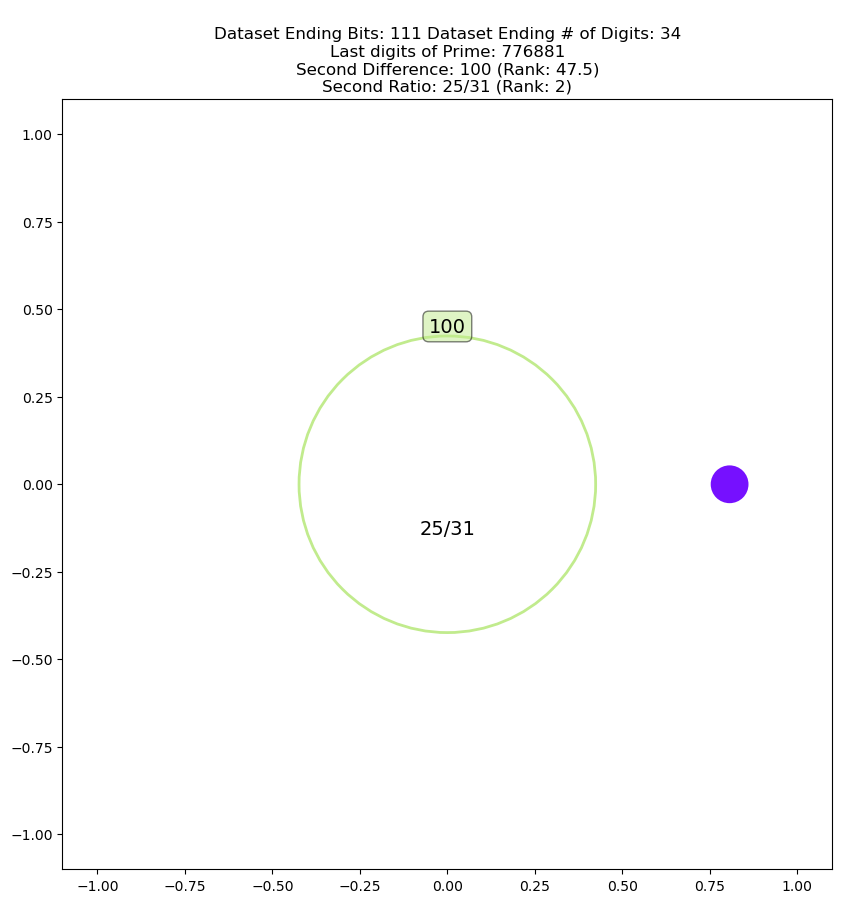

In [20]:
ani = run_config_animation('111bit100_20230718_131326')

Loading data...
Setting up the figure...
Creating the animation...


  0%|                                 | 3/998 [00:00<00:47, 20.80it/s]

Saving the animation to 10bit1000_20230717_165833/10bit1000_animation.mp4...


1001it [01:39, 10.05it/s]                                             


Animation created successfully!
Animation saved to: 10bit1000_20230717_165833/10bit1000_animation.mp4


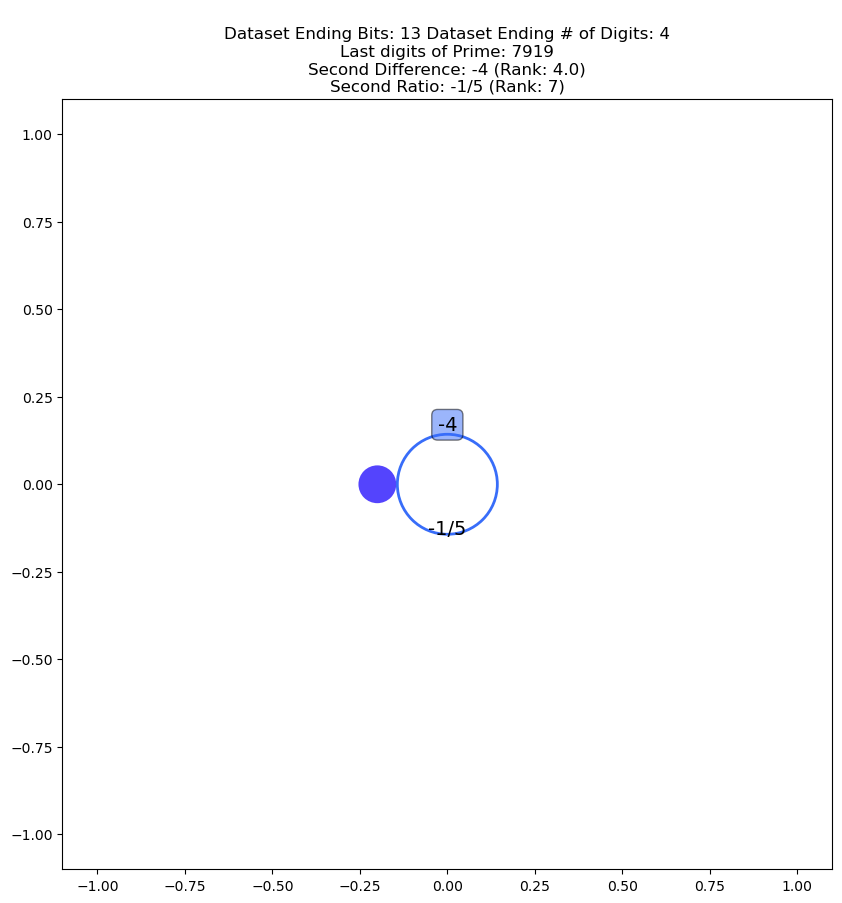

In [21]:
ani = run_config_animation('10bit1000_20230717_165833')

In [22]:
def plot_sd_distribution(filename):
    """Plot a histogram of the distribution of second differences."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    # Load the data
    data = pd.read_csv(filename)

    # Separate positive, negative and zero values
    positive_sd = data[data['Second Difference'] > 0]['Second Difference']
    negative_sd = data[data['Second Difference'] < 0]['Second Difference']
    zero_sd = data[data['Second Difference'] == 0]['Second Difference']

    # Create a histogram
    fig, ax = plt.subplots()

    # Plot separate histograms for positive, negative and zero values
    ax.hist(positive_sd, bins=range(int(min(positive_sd)), int(max(positive_sd)) + 1), color='g', label='Positive')
    ax.hist(negative_sd, bins=range(int(min(negative_sd)), int(max(negative_sd)) + 1), color='r', label='Negative')
    ax.hist(zero_sd, bins=range(int(min(zero_sd)), int(max(zero_sd)) + 1), color='b', label='Zero')

    # Compute heights and bin edges for all data
    counts, edges = np.histogram(data['Second Difference'], bins=range(int(min(data['Second Difference'])), int(max(data['Second Difference'])) + 1))

    # Compute the bin width
    bin_width = edges[1] - edges[0]

    # Get indices of the 12 largest bins
    largest_bins = counts.argsort()[-11:]

    # Loop through the largest bins
    for idx in largest_bins:
        # Compute the height of the text box
        text_height = 0.03 * ax.get_ylim()[1]

        # Compute the position of the text box
        text_position = edges[idx] + 0.5 * bin_width, counts[idx] + text_height

        # If the bin is not too tall, label it
        if counts[idx] < ax.get_ylim()[1] - 2 * text_height:
            ax.text(*text_position, str(int(edges[idx])), ha='center', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5))

    # Set labels and title
    ax.set_xlabel('Second Difference')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Second Differences')
    ax.legend()

    # Save the plot to a file
    output_filename = filename.rsplit('.', 1)[0] + '_sd_distribution_plot.png'
    plt.savefig(output_filename)

    print(f"Second difference distribution plot saved to: {output_filename}")


Second difference distribution plot saved to: 10bit1000000_20230717_022637/10bit1000000_primes_sd_distribution_plot.png


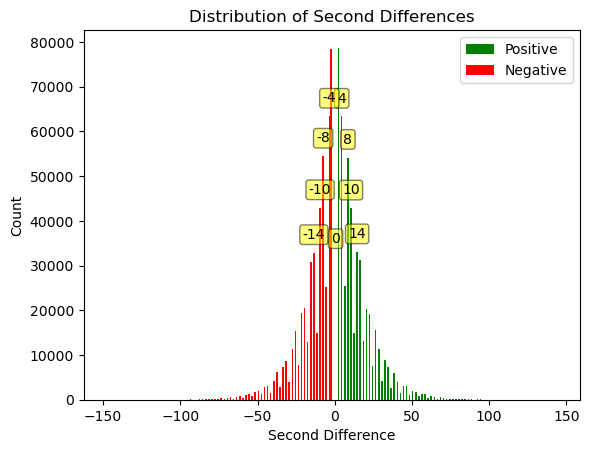

In [9]:
plot_sd_distribution("10bit1000000_20230717_022637/10bit1000000_primes.csv")


In [23]:
def calculate_sd_bias(filename):
    """
    Calculate the bias in second differences.
    
    The Prime Number Theorem predicts that primes 
    are getting further apart from each other 
    as numbers get larger and larger. 
    
    This calculates how much of a bias there is
    and in a positive or negative direction
    Over the dataset.   
    
    
    """
    import pandas as pd

    # Load the data
    data = pd.read_csv(filename)

    # Calculate the counts of positive and negative second differences
    positive_count = (data['Second Difference'] > 0).sum()
    negative_count = (data['Second Difference'] < 0).sum()

    # Calculate the bias
    bias = (positive_count - negative_count) / len(data)

    return bias

In [24]:
bias = calculate_sd_bias("10bit1000000_20230717_022637/10bit1000000_primes.csv")
print(f"The bias in second differences is: {bias}")

The bias in second differences is: 0.000342000684001368


In [25]:
def plot_sr_distribution(filename):
    """Plot a histogram of the distribution of second ratios."""
    import pandas as pd
    import matplotlib.pyplot as plt
    from fractions import Fraction

    # Load the data
    data = pd.read_csv(filename)

    # Convert second ratios to float
    data['Second Ratio Float'] = data['Second Ratio'].apply(lambda x: 0 if x == '0' else float(Fraction(x)))

    # Separate positive and negative values
    positive_sr = data[data['Second Ratio Float'] > 0]['Second Ratio Float']
    negative_sr = data[data['Second Ratio Float'] < 0]['Second Ratio Float']

    # Create a histogram
    fig, ax = plt.subplots()
    bins = 50
    counts, edges, _ = ax.hist([positive_sr, negative_sr], bins=bins, label=['Positive', 'Negative'])

    # Find the indices of the tallest bars
    max_indices = counts.flatten().argsort()[-20:]

    # Label the tallest bars
    for idx in max_indices:
        bar_height = counts.flatten()[idx]
        bar_center = (edges[idx % bins] + edges[(idx % bins) + 1]) / 2
        # Look up the original SR fraction for this bar
        original_sr = data.loc[(data['Second Ratio Float'] > edges[idx % bins]) & (data['Second Ratio Float'] <= edges[(idx % bins) + 1]), 'Second Ratio'].mode().values[0]
        ax.text(bar_center, bar_height, original_sr, ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Second Ratio')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Second Ratios')
    ax.legend()

    # Save the plot to a file
    output_filename = filename.rsplit('.', 1)[0] + '_sr_distribution_plot.png'
    plt.savefig(output_filename)

    print(f"Second ratio distribution plot saved to: {output_filename}")


Second ratio distribution plot saved to: 10bit1000000_20230717_022637/10bit1000000_primes_sr_distribution_plot.png


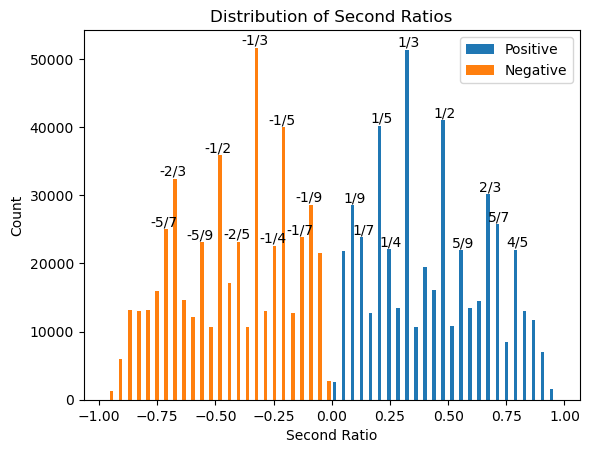

In [26]:
plot_sr_distribution("10bit1000000_20230717_022637/10bit1000000_primes.csv")

In [27]:
def calculate_sr_bias(filename):
    """
    Calculate the bias in second ratios.
         
    The Prime Number Theorem predicts that primes 
    are getting further apart from each other 
    as numbers get larger and larger. 
    
    This calculates how much of a bias there is
    and in a positive or negative direction
    Over the dataset.   
    
    """
    import pandas as pd
    from fractions import Fraction

    # Load the data
    data = pd.read_csv(filename)

    # Convert second ratios to float
    data['Second Ratio Float'] = data['Second Ratio'].apply(lambda x: 0 if x == '0' else float(Fraction(x)))

    # Calculate the counts of positive and negative second ratios
    positive_count = (data['Second Ratio Float'] > 0).sum()
    negative_count = (data['Second Ratio Float'] < 0).sum()

    # Calculate the bias
    bias = (positive_count - negative_count) / len(data)

    return bias

In [28]:
bias = calculate_sr_bias("10bit1000_20230717_165833/10bit1000_primes.csv")
print(f"The bias in second ratios is: {bias}")

The bias in second ratios is: 0.01903807615230461


Second ratio distribution plot saved to: 256bit1000_20230718_105330/256bit1000_primes_sr_distribution_plot.png


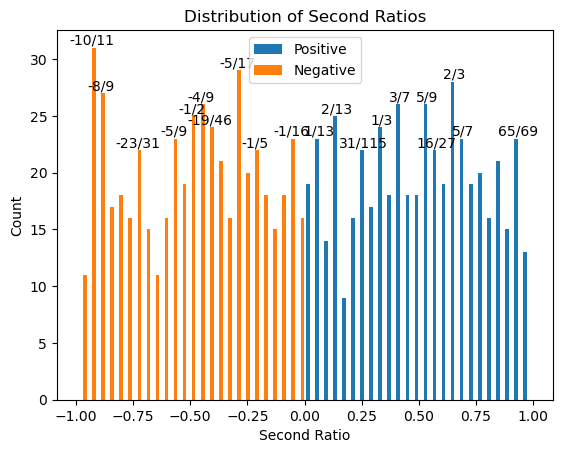

In [59]:
plot_sr_distribution("256bit1000_20230718_105330/256bit1000_primes.csv")

In [31]:
!cat config.json

{
  "num_bits": 1024,
  "num_primes": 400,
  "start_number": "random",
  "write_output": true,
  "output_primes": true,
  "output_second_differences": true,
  "output_second_ratios": true,
  "output_sd_sr_combinations": true,
  "output_named_prime_sets": true,
  "output_named_prime_sets_totals": true,
  "miller_rabin_iterations": 6,
  "num_digits": "auto"
}


In [32]:
primes, sd, sr, sd_sr_combinations, named_prime_sets = run_from_config('config.json')

Generating primes...
100.0 % done             
Calculating named prime sets...
Done!
Calculating second differences...
Calculating second ratios...
Calculating SD-SR combinations...
Calculating named prime sets...
Done!
Full path to the output directory: /Users/tem/primejuly/1024bit400_20230718_204913
Current working directory: /Users/tem/primejuly


Loading data...
Setting up the figure...
Creating the animation...


  1%|▏                                | 3/398 [00:00<00:18, 21.24it/s]

Saving the animation to 1024bit400_20230718_204913/1024bit400_animation.mp4...


401it [00:41,  9.59it/s]                                              


Animation created successfully!
Animation saved to: 1024bit400_20230718_204913/1024bit400_animation.mp4


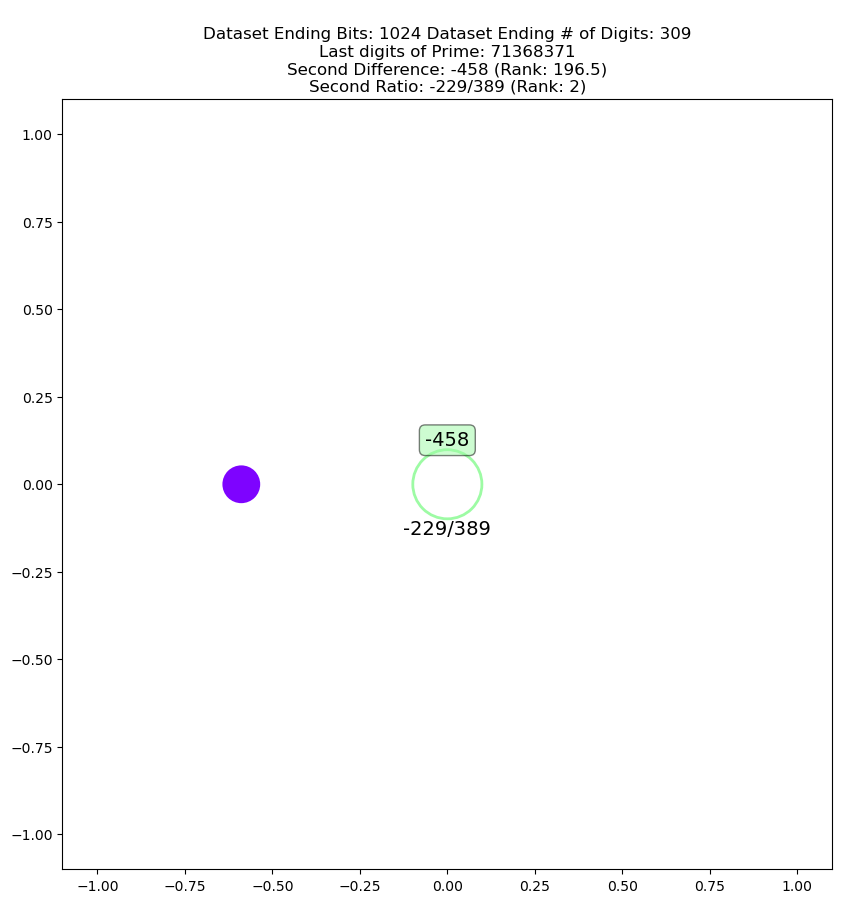

In [33]:
ani = run_config_animation('1024bit400_20230718_204913')

In [72]:
primes, sd, sr, sd_sr_combinations, named_prime_sets = run_from_config('config.json')

Generating primes...
100.0 % done             
Calculating named prime sets...
Done!
Calculating second differences...
Calculating second ratios...
Calculating SD-SR combinations...
Calculating named prime sets...
Done!
Full path to the output directory: /Users/tem/primejuly/101bit1000_20230718_122139
Current working directory: /Users/tem/primejuly


In [73]:
primes[0]

2212145753789239017579749267371

In [74]:
primes[-1]

2212145753789239017579749338049

In [75]:
primes[-1]- primes[0]

70678

In [76]:
!cat config.json

{
  "num_bits": 101,
  "num_primes": 1000,
  "start_number": "random",
  "write_output": true,
  "output_primes": true,
  "output_second_differences": true,
  "output_second_ratios": true,
  "output_sd_sr_combinations": true,
  "output_named_prime_sets": true,
  "output_named_prime_sets_totals": true,
  "miller_rabin_iterations": 6,
  "num_digits": "auto"
}


Loading data...
Setting up the figure...
Creating the animation...


  3%|█                                 | 3/98 [00:00<00:04, 21.30it/s]

Saving the animation to 111bit100_20230718_131326/111bit100_animation.mp4...


101it [00:10,  9.68it/s]                                              


Animation created successfully!
Animation saved to: 111bit100_20230718_131326/111bit100_animation.mp4


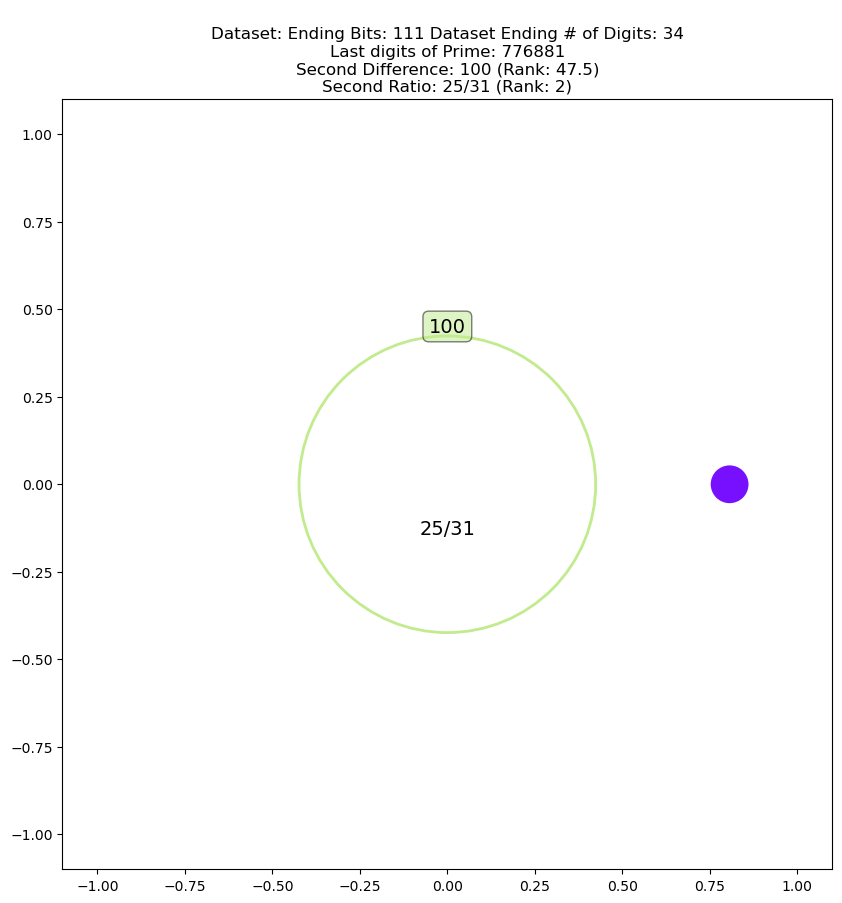

In [113]:
ani = run_config_animation('111bit100_20230718_131326')

In [79]:
!cat config.json

{
  "num_bits": 111,
  "num_primes": 1000,
  "start_number": "random",
  "write_output": true,
  "output_primes": true,
  "output_second_differences": true,
  "output_second_ratios": true,
  "output_sd_sr_combinations": true,
  "output_named_prime_sets": true,
  "output_named_prime_sets_totals": true,
  "miller_rabin_iterations": 6,
  "num_digits": "auto"
}


In [80]:
primes, sd, sr, sd_sr_combinations, named_prime_sets = run_from_config('config.json')

Generating primes...
100.0 % done             
Calculating named prime sets...
Done!
Calculating second differences...
Calculating second ratios...
Calculating SD-SR combinations...
Calculating named prime sets...
Done!
Full path to the output directory: /Users/tem/primejuly/111bit1000_20230718_122528
Current working directory: /Users/tem/primejuly


Loading data...
Setting up the figure...
Creating the animation...


  0%|                                 | 3/998 [00:00<00:47, 21.05it/s]

Saving the animation to 101bit1000_20230718_122139/101bit1000_animation.mp4...


1001it [01:38, 10.18it/s]                                             


Animation created successfully!
Animation saved to: 101bit1000_20230718_122139/101bit1000_animation.mp4


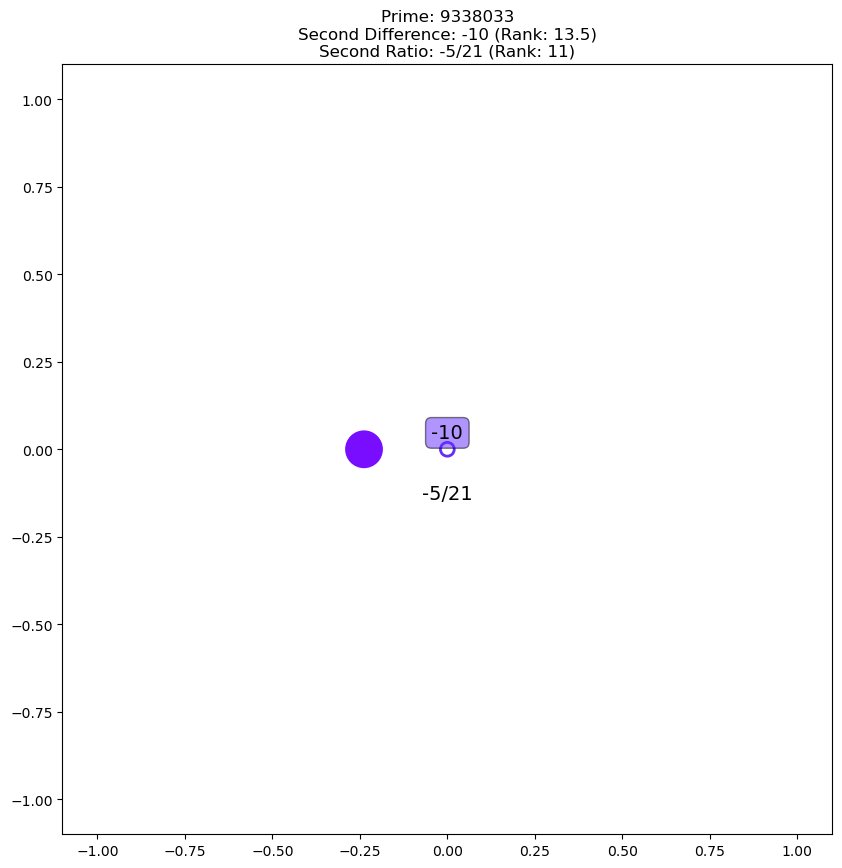

In [86]:
ani = run_config_animation('101bit1000_20230718_122139')

Loading data...
Setting up the figure...
Creating the animation...


  0%|▏                                | 4/998 [00:00<01:11, 13.93it/s]

Saving the animation to 111bit1000_20230718_122528/111bit1000_animation.mp4...


1001it [01:40, 10.00it/s]                                             


Animation created successfully!
Animation saved to: 111bit1000_20230718_122528/111bit1000_animation.mp4


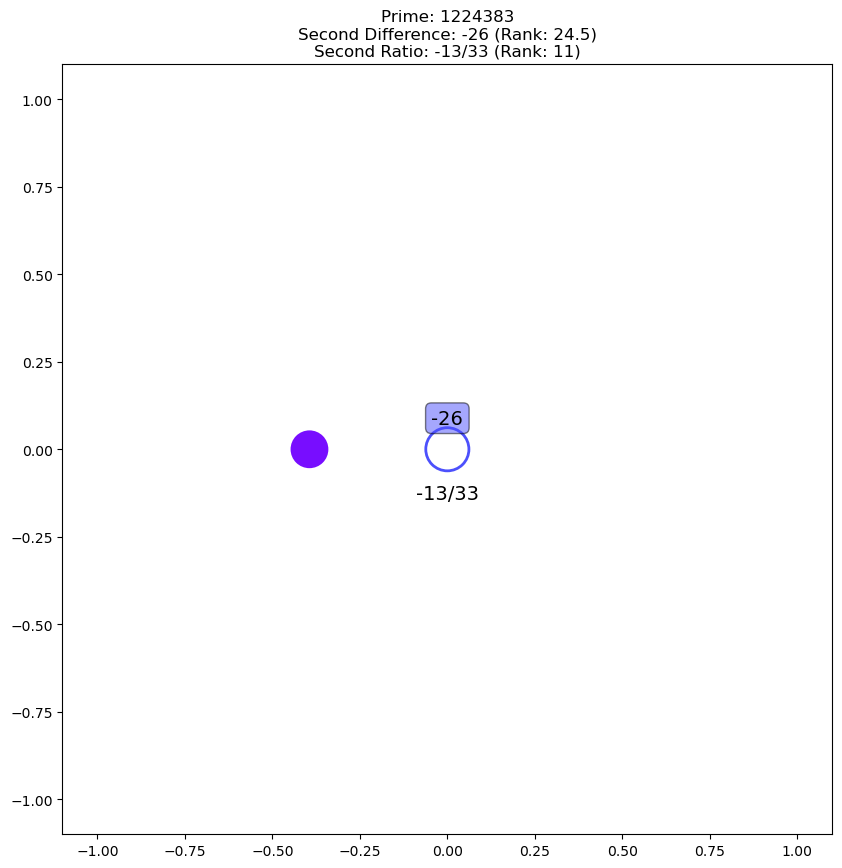

In [92]:
ani = run_config_animation('111bit1000_20230718_122528')